# p53 Experiment in GPJax

Re-implementation of latent force functions using GPJax library

In [33]:
import numpy as np
import gpjax as gpx
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

        
colors = rcParams["axes.prop_cycle"].by_key()["color"]

The original data from *Barenco et al.* used a training set of $5$ known $p53$ target genes:

| **Target** | **Probeset** |
|----------|----------|
| *DDB2* | 203409_at  |
| *p21*  | 202284_s_at   |
| *SESN1/hPA26*   | 218346_s_at   |
| *BIK*   | 205780_at  |
| *TNFRSF10b*   | 209294_x_at, 209295_at, 210405_x_at   |

In [34]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

In [35]:
def plot_all_genes_expression(original_df, transformed_expressions, gene_names, times):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot all original expressions on the first subplot
    for gene_name in gene_names:
        # Calculate the mean of triplicates for the original expression levels
        original_means = original_df.loc[gene_name].values.reshape(7, 3).mean(axis=1)
        axes[0].plot(times, original_means, '-o', label=gene_name)
        
    axes[0].set_title('Original Expression Levels')
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('Expression Level')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot all log-normalized expressions on the second subplot
    for i, gene_name in enumerate(gene_names):
        # Calculate the mean of triplicates for the transformed expression levels
        transformed_means = transformed_expressions[i].reshape(7, 3).mean(axis=1)
        axes[1].plot(times, transformed_means, '-o', label=gene_name)
        
    axes[1].set_title('Log-normalized Expression Levels')
    axes[1].set_xlabel('Time (hours)')
    axes[1].set_ylabel('Transformed Expression Level')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

/var/folders/bl/8jtm6jln6xl3rgh70czj8_8r0000gn/T/ipykernel_48338/2737005937.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


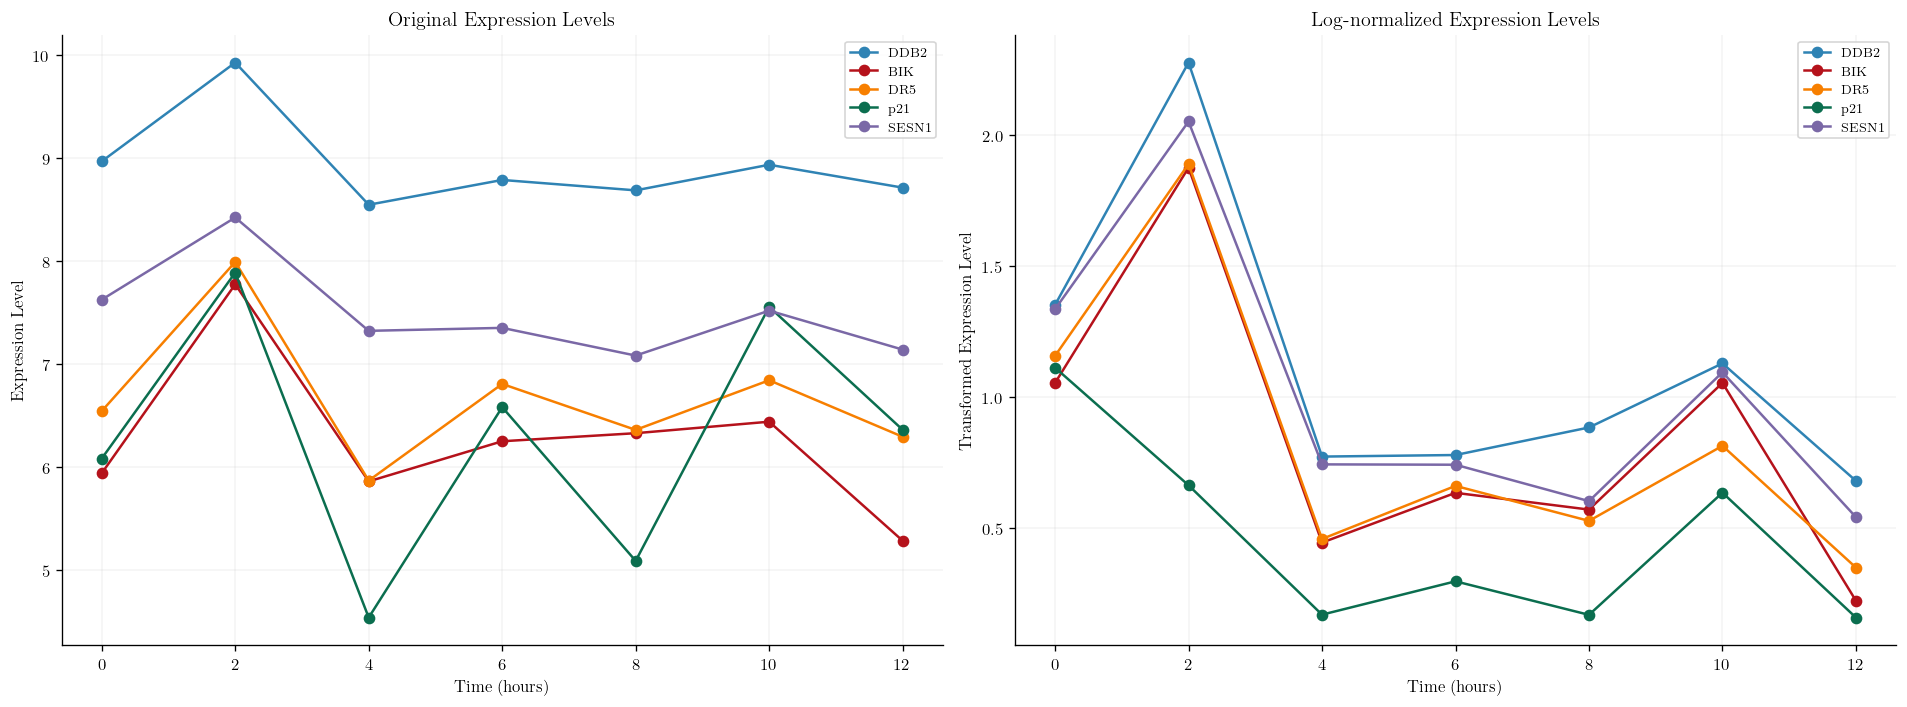

In [36]:
gene_names = ['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53']  # Assuming these are your genes of interest
plot_all_genes_expression(original_genes_df, genes_transformed.swapaxes(0, 1), gene_names[:-1], times)

## Gaussian process implementation

Now that the data has been correctly pre-processed the Gaussian processes (GPs) can be implemented in `GPJax`.

In [37]:
p53_data = JAXP53_Data(replicate=3)
train_t , train_y = flatten_dataset_jax(p53_data)
type(train_t), type(train_y)

(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

In [38]:
train_y

Array([0.17238177, 0.23264388, 1.92464882, 1.22534649, 0.68403809,
       0.46037239, 0.89290156, 0.19510971, 0.09759664, 2.16464784,
       0.89689396, 0.26302294, 0.11858324, 0.28305556, 0.08857048,
       0.14190979, 1.35116539, 0.94570607, 0.27215756, 0.2544362 ,
       0.51773185, 0.01876506, 0.12216444, 1.24857003, 0.53118723,
       0.16929122, 0.11145665, 0.19135888, 0.20769934, 0.21061597,
       1.82892805, 1.24125571, 0.5166152 , 0.46197937, 0.64339332],      dtype=float64)

In [39]:
train_t

Array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10.,
       12.,  0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8.,
       10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64)

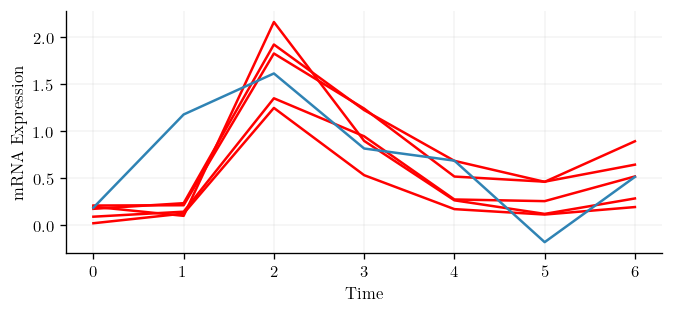

In [40]:
for i in range(5):
    plt.plot(p53_data.m_observed[0, i], color='red')
plt.plot(p53_data.f_observed[0, 0])
plt.xlabel('Time')
plt.ylabel('mRNA Expression')
plt.show()

In [41]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

## Using GPJax for transcriptional regulation modelling

1. Define GP Model
   - define kernel (RBF)
   - define likelihood
   - define mean function
2. Set the prior (done implicitly through choice of kernel & mean function)
3. Optimise hyperparameters of the GP model based on data
4. Make predictions & plot results

In [42]:
import gpjax as gpx
import jax.random as jr
from jax import jit

# Set random key
key = jr.PRNGKey(123)

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) 
Y = train_y.reshape(-1, 1)

x_test = np.linspace(0, 12, 100).reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

In [43]:
train_t

Array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10.,
       12.,  0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8.,
       10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12.], dtype=float64)

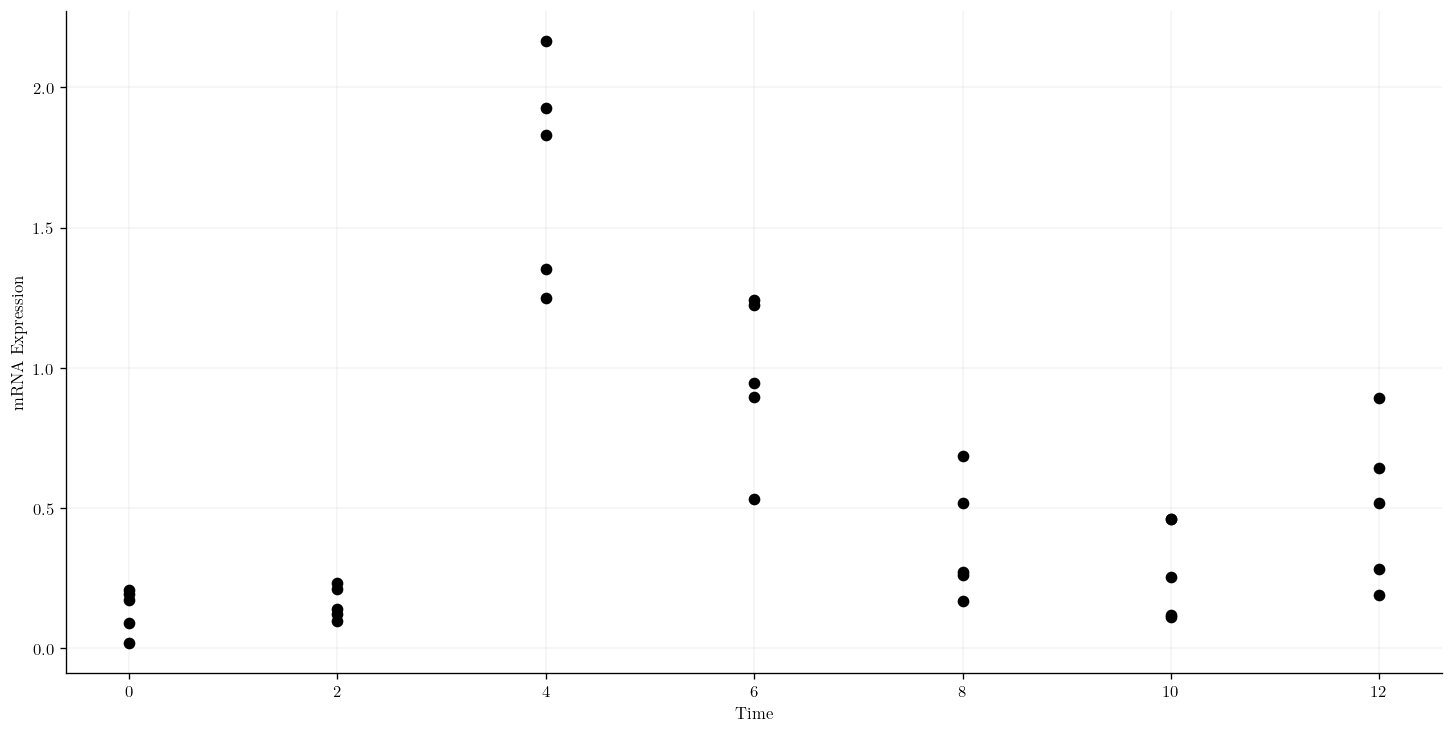

In [44]:
# Plot X & Y data
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'o', color='black')
plt.xlabel('Time')
plt.ylabel('mRNA Expression')
plt.show()

In [45]:
X

Array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]], dtype=float64)

In [46]:
import abc
import dataclasses
from functools import partial

from beartype.typing import (
    Callable,
    List,
    Union,
)
import jax.numpy as jnp
from jaxtyping import (
    Float,
    Num,
)

from gpjax.base import (
    Module,
    param_field,
    static_field,
)
from gpjax.typing import Array


@dataclasses.dataclass
class AbstractMeanFunction(Module):
    r"""Mean function that is used to parameterise the Gaussian process."""

    @abc.abstractmethod
    def __call__(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points. This method is required for all subclasses.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1]: The evaluated mean function.
        """
        raise NotImplementedError

    def __add__(
        self, other: Union["AbstractMeanFunction", Float[Array, " O"]]
    ) -> "AbstractMeanFunction":
        r"""Add two mean functions.

        Args:
            other (AbstractMeanFunction): The other mean function to add.

        Returns
        -------
            AbstractMeanFunction: The sum of the two mean functions.
        """
        if isinstance(other, AbstractMeanFunction):
            return SumMeanFunction([self, other])

        return SumMeanFunction([self, Constant(other)])

    def __radd__(
        self,
        other: Union[
            "AbstractMeanFunction", Float[Array, " O"]
        ],  # TODO should this be ScalarFloat? or Num?
    ) -> "AbstractMeanFunction":
        r"""Add two mean functions.

        Args:
            other (AbstractMeanFunction): The other mean function to add.

        Returns
        -------
            AbstractMeanFunction: The sum of the two mean functions.
        """
        return self.__add__(other)

    def __mul__(
        self,
        other: Union[
            "AbstractMeanFunction", Float[Array, " O"]
        ],  # TODO should this be ScalarFloat? or Num?
    ) -> "AbstractMeanFunction":
        r"""Multiply two mean functions.

        Args:
            other (AbstractMeanFunction): The other mean function to multiply.

        Returns
        -------
            AbstractMeanFunction: The product of the two mean functions.
        """
        if isinstance(other, AbstractMeanFunction):
            return ProductMeanFunction([self, other])

        return ProductMeanFunction([self, Constant(other)])

    def __rmul__(
        self,
        other: Union[
            "AbstractMeanFunction", Float[Array, " O"]
        ],  # TODO should this be ScalarFloat? or Num?
    ) -> "AbstractMeanFunction":
        r"""Multiply two mean functions.

        Args:
            other (AbstractMeanFunction): The other mean function to multiply.

        Returns
        -------
            AbstractMeanFunction: The product of the two mean functions.
        """
        return self.__mul__(other)


@dataclasses.dataclass
class Constant(AbstractMeanFunction):
    r"""Constant mean function.

    A constant mean function. This function returns a repeated scalar value for all
    inputs.  The scalar value itself can be treated as a model hyperparameter and
    learned during training but defaults to 1.0.
    """

    constant: Float[Array, " O"] = param_field(jnp.array([0.0]))

    def __call__(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        mean = jnp.ones((x.shape[0], 1)) * self.constant
        print(mean.shape, x.shape)
        return mean


@dataclasses.dataclass
class Zero(Constant):
    r"""Zero mean function.

    The zero mean function. This function returns a zero scalar value for all
    inputs. Unlike the Constant mean function, the constant scalar zero is fixed, and
    cannot be treated as a model hyperparameter and learned during training.
    """
    constant: Float[Array, " O"] = static_field(jnp.array([0.0]), init=False)

In [47]:
kernel = gpx.kernels.RBF()
meanf = Zero()
prior = gpx.gps.Prior(kernel, meanf)

In [48]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    return ax

(100, 1) (100, 1)


/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


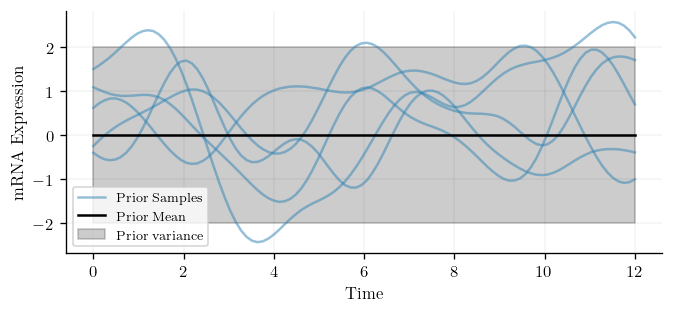

In [49]:
prior_dist = prior.predict(x_test)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(5,))

fig, ax = plt.subplots()
ax.plot(x_test, samples.T, alpha=0.5, color='C0', label = 'Prior Samples')
ax.plot(x_test, prior_mean, color='black', label = 'Prior Mean')
ax.fill_between(x_test.flatten(), prior_mean - 2 * np.sqrt(prior_std), prior_mean + 2 * np.sqrt(prior_std), color='black', alpha=0.2, label = 'Prior variance')
ax.set_xlabel('Time')
ax.set_ylabel('mRNA Expression')

ax.legend(loc='best')
ax = clean_legend(ax)

Having defined our GP, we proceed to define a description of our data $\mathcal{D}$ conditional on our knowledge of $f(\cdot)$ --- this is exactly the notion of a likelihood function $p(\mathcal{D} | f(\cdot))$. While the choice of likelihood is a critical in Bayesian modelling, for simplicity we consider a Gaussian with noise parameter $\alpha$

In [50]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=p53_gpjax_dataset.n)

The posterior is proportional to the prior multiplied by the likelihood, written as
$$ 
p(f(\cdot) | \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} | f(\cdot)).
$$

Mimicking this construct, the posterior is established in GPJax through the `*` operator.

In [51]:
posterior = prior * likelihood

In [52]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=p53_gpjax_dataset)

(35, 1) (35, 1)


Array(40.82697246, dtype=float64)

In [53]:
#negative_mll = jit(negative_mll)

Can now define an optimiser, I will use the `bfgs` optimiser from the `GPjax regression` tutorial

In [54]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=p53_gpjax_dataset,
)

(35, 1) (35, 1)
(35, 1) (35, 1)
Optimization terminated successfully.
         Current function value: 12.420297
         Iterations: 11
         Function evaluations: 18
         Gradient evaluations: 18


# Prediction

Now that the posterior has been defined with optimised hyperparameter values, the GP's predictive distribution can be queried at novel test inputs. To achieve this, the defined `posterior` and `likelihood` are used at the test inputs to obtain the predictive distribution as a `Distrax` multivariate Gaussian upon which `mean` and `stddev` can be used to extract the predictive mean and standard deviation.

In [55]:
latent_dist = opt_posterior.predict(x_test, train_data=p53_gpjax_dataset)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

(35, 1) (35, 1)
(100, 1) (100, 1)


With the predictions and their uncertainties acquired, the GP's performance can be plotted

In [56]:
import matplotlib as mpl
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

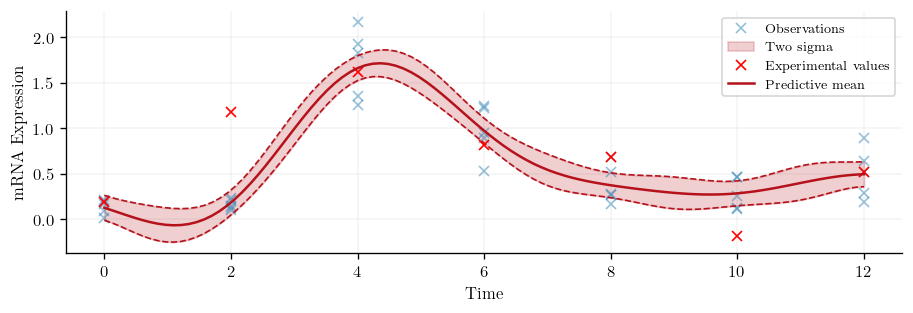

In [57]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(X, Y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_test.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)

ax.plot(
    list(range(0,13,2)), f_observed, "x", label="Experimental values", color='red',
)

ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Expression")
ax = clean_legend(ax)